# Тема: Численные методы    
# Проект: Определение стоимости автомобилей    

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

**План выполнения проекта**

Сохранена предложенная структура проекта    
После каждого пункта следуют выводы и в заключение подводится общий итог

- 1 Подготовка данных
    - Импорт библиотек
    - Открытие файла данных
    - Анализ датасета
- 2 Обучение моделей
    - подбор моделей для регрессии
    - выбор лучших моделей
    - подбор основных гиперпараметров для этих моделей
- 3 Анализ моделей
    - анализ времени работы и метрик результатов работы моделей
    - выбор лучшей модели и ее оценка на тестовой выборке
    - подведение итогов

## Подготовка данных

In [1]:
# Импорт библиотек и задание параметров

import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import phik
import time
import itertools
from datetime import date

from sklearn import set_config
from sklearn.compose import ColumnTransformer
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.feature_extraction import FeatureHasher
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, Ridge, ElasticNet, Lasso
from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, QuantileTransformer
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeRegressor

from category_encoders import TargetEncoder, CatBoostEncoder, BinaryEncoder
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

set_config(transform_output="pandas")
plt.rcParams["figure.figsize"] = (20, 5)
pd.options.display.precision = 2
RANDOM_STATE = 42

In [2]:
# Загрузка данных и вывод статистик

def load_df(file_name, sep=',', path='Yandex®', **params):
    
    pth1 = file_name
    pth2 = path + file_name


    if os.path.exists(pth1):
        return pd.read_csv(pth1, **params)
    elif os.path.exists(pth2):
        return pd.read_csv(pth2, **params)
    else:
        print(f"Cannot find file {file_name} in the local folders, loading from remote")
        return pd.read_csv(pth2, **params)
    
def display_statistics(data, freq_values=True):
    
    if freq_values:
        freq_name = 'freq_values'
        freq_num = 3
    else:
        freq_name = 'most_freq'
        freq_num = 1
    return pd.DataFrame(
        {'type': [data[x].dtypes for x in data.columns],
         'count' : [data[x].count() for x in data.columns],
         'NaNs' : [data[x].isna().sum() for x in data.columns],
         'zero_values': [data[x].eq(0).sum() for x in data.columns],
         'unique_values': [data[x].nunique() for x in data.columns],
         freq_name: [data[x].value_counts().head(freq_num).to_dict() for x in data.columns],
         'min': [data[x].min() if data[x].dtype!=object else '---' for x in data.columns],
         'mean': [data[x].mean() if data[x].dtype!=object else '---' for x in data.columns],
         'max': [data[x].max() if data[x].dtype!=object else '---' for x in data.columns],
         'std': [data[x].std() if data[x].dtype!=object else '---' for x in data.columns],
         'lo_count': [lo_hi_count(data, x) for x in data.columns],
         'hi_count': [lo_hi_count(data, x, low=False) for x in data.columns],
        }, index = [x for x in data.columns])

def lo_hi_count(data, col, low=True):
    
    if data[col].dtype not in [float, int, 'datetime64[ns]']:
        return '---'
    Q1 = np.nanquantile(data[col], 0.25)
    Q3 = np.nanquantile(data[col], 0.75)
    if low:
        return data[data[col] <= Q1 - 1.5 * (Q3 - Q1)][col].count()
    else:
        return data[data[col] >= Q3 + 1.5 * (Q3 - Q1)][col].count()

In [3]:
# Разбиение датасета на выборки

def train_test_val_split(data, train_size=0.7, test_val_ratio=0.5, drop_target='price', silent=False, random_state=RANDOM_STATE):
    
    X_train, X_test, y_train, y_test = train_test_split(data.drop(drop_target, axis=1) , 
                                                        data[drop_target], 
                                                        train_size=train_size, 
                                                        shuffle=True, 
                                                        random_state=random_state)
    X_test, X_valid, y_test, y_valid = train_test_split(X_test, y_test, 
                                                        train_size=test_val_ratio, 
                                                        shuffle=True, 
                                                        random_state=random_state)
    if not silent:
        print(f'Обучающий набор: X: {X_train.shape}, y: {y_train.shape}')
        print(f'Валидационный набор: X: {X_valid.shape}, y: {y_valid.shape}')
        print(f'Тестовый набор: X: {X_test.shape}, y: {y_test.shape}') 
    
    return X_train, X_valid, X_test, y_train, y_valid, y_test


# Измерение времени обучения и предсказания

def fit_predict_mark_time(model_name, model, X_train, y_train, X_valid, y_valid, verbose=True, tune='[default]'):
   
    start = time.time()
    model.fit(X_train, y_train)
    fit_time = round(time.time() - start)

    start = time.time()
    y_pred = model.predict(X_train)
    predict_train_time = round(time.time() - start) 
    rmse_train = mse(y_train, y_pred, squared=False).round(2)
    
    start = time.time()
    y_pred = model.predict(X_valid)
    predict_valid_time = round(time.time() - start) 
    rmse_valid = mse(y_valid, y_pred, squared=False).round(2)
    
    if tune != '[default]':
        tune = [_ for _ in tune.values()]
    if verbose:
        print(f'{model_name}:{tune}'.ljust(35), 
              f'RMSE (train/valid): {rmse_train}/{rmse_valid},', 
              f'time (fit/train/valid, s): {fit_time}/{predict_train_time}/{predict_valid_time}')

    return [rmse_train, rmse_valid, fit_time, predict_train_time, predict_valid_time, model.get_params()]

In [4]:
# Кодирование числовых переменных

def scale(scaler, subsets):
    
    X_train, X_valid, X_test, y_train, y_valid, y_test = subsets
    features = list(X_train.columns)
    print(f'{scaler}'.ljust(20), end=":")
    
    return (pd.DataFrame(scaler.fit_transform(X_train), columns=features), 
                pd.DataFrame(scaler.transform(X_valid), columns=features), 
                X_test, y_train, y_valid, y_test)

In [5]:
# Кодирование категориальных переменных

def encode(encoder, subsets):
    encoder = encoder()
    X_train, X_valid, X_test, y_train, y_valid, y_test = subsets
    X_train = encoder.fit_transform(X_train, y_train)
    X_valid = encoder.transform(X_valid)
    
    return X_train, X_valid, X_test, y_train, y_valid, y_test

def one_hot_encoder(subsets):
    encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore', drop='first')
    target = ['model_name']
    X_train, X_valid, X_test, y_train, y_valid, y_test = subsets
    columns_to_drop = list(X_train.select_dtypes(include=object).columns)

    X_array = encoder.fit_transform(X_train[target])
    X_train = X_train.drop(columns_to_drop,axis=1).join(X_array)
    X_array = encoder.transform(X_valid[target]) 
    X_valid = X_valid.drop(columns_to_drop,axis=1).join(X_array)
    
    return X_train, X_valid, X_test, y_train, y_valid, y_test

def feature_hasher(subsets):
    X_train, X_valid, X_test, y_train, y_valid, y_test = subsets
    hasher = FeatureHasher(n_features=50, input_type='string')
    columns_to_drop = list(X_train.select_dtypes(include=object).columns)
    
    X_hashed = hasher.fit_transform(X_train['model_name'].to_numpy().reshape(-1,1))
    X_train = X_train.drop(columns_to_drop, axis=1)
    X_hashed = pd.DataFrame(X_hashed.toarray(), index=X_train.index)
    X_train = X_train.join(X_hashed)

    X_hashed_valid = hasher.transform(X_valid['model_name'].to_numpy().reshape(-1,1))
    X_valid = X_valid.drop(columns_to_drop, axis=1)
    X_hashed_valid = pd.DataFrame(X_hashed_valid.toarray(), index=X_valid.index)
    X_valid = X_valid.join(X_hashed_valid)

    return X_train, X_valid, X_test, y_train, y_valid, y_test

In [6]:
# Загрузка датасета и вывод информации

df_raw = load_df('autos.csv', parse_dates=['DateCrawled', 'DateCreated', 'LastSeen'])
df_raw.info()
df_raw.head()

Cannot find file autos.csv in the local folders, loading from remote
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   DateCrawled        354369 non-null  datetime64[ns]
 1   Price              354369 non-null  int64         
 2   VehicleType        316879 non-null  object        
 3   RegistrationYear   354369 non-null  int64         
 4   Gearbox            334536 non-null  object        
 5   Power              354369 non-null  int64         
 6   Model              334664 non-null  object        
 7   Kilometer          354369 non-null  int64         
 8   RegistrationMonth  354369 non-null  int64         
 9   FuelType           321474 non-null  object        
 10  Brand              354369 non-null  object        
 11  Repaired           283215 non-null  object        
 12  DateCreated        354369 non-n

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31,0,60437,2016-04-06 10:17:21


In [7]:
display_statistics(df_raw, freq_values=False)

,type,count,NaNs,zero_values,unique_values,most_freq,min,mean,max,std,lo_count,hi_count
DateCrawled,datetime64[ns],354369,0,0,271174,{2016-03-24 14:49:47: 7},2016-03-05 14:06:22,2016-03-21 12:58:10.450648320,2016-04-07 14:36:58,9 days 02:27:20.311635856,0,0
Price,int64,354369,0,10772,3731,{0: 10772},0,4416.66,20000,4514.16,---,---
VehicleType,object,316879,37490,0,8,{'sedan': 91457},---,---,---,---,---,---
RegistrationYear,int64,354369,0,0,151,{2000: 24490},1000,2004.23,9999,90.23,---,---
Gearbox,object,334536,19833,0,2,{'manual': 268251},---,---,---,---,---,---
Power,int64,354369,0,40225,712,{0: 40225},0,110.09,20000,189.85,---,---
Model,object,334664,19705,0,250,{'golf': 29232},---,---,---,---,---,---
Kilometer,int64,354369,0,0,13,{150000: 238209},5000,128211.17,150000,37905.34,---,---
RegistrationMonth,int64,354369,0,37352,13,{0: 37352},0,5.71,12,3.73,---,---
FuelType,object,321474,32895,0,7,{'petrol': 216352},---,---,---,---,---,---


Переименовываем столбцы as snake_style.  
'registration_year' и 'registration_month' - отражают срок службы авто, преобразуем их в возраст машины, дату исследования берем из максимума значений столбцов даты.  
Из 'brand' и 'model' создаем один признак - 'model_name'.
Убираем дубликаты и лишние столбцы: 'date_crawled', 'date_created', 'number_of_pictures', 'postal_code', 'last_seen'.  
Фильтруем столбцы, отсеивая следующие аномальные значения:  
  - power - менее 10 и более 500  
  - price - менее 500
  - возраст менее 0 и более 100  
  
Убираем в таргете NaNs

In [8]:
def rename_columns(df):
    df.rename(columns = lambda string: ''.join(['_'+x.lower() 
                                                if x.isupper() and i!=0 
                                                else x.lower() for i, x in enumerate(string)]),
              inplace=True)
    return df

In [9]:
# Оформляем функции для трансформера

def create_model_name(df):
    df['model_name'] = df['brand'] + np.where(df['model'].isna(), '', ' '+ df['model'])
    return df

def drop_excess_columns(df):
    df.drop(['date_crawled', 'date_created', 'last_seen', 'number_of_pictures', 'postal_code',
             'registration_month', 'brand', 'model'], 
            axis=1, inplace=True)
    return df

def drop_excess_rows(df):
    df.drop_duplicates(inplace=True)
    return df

def filter_column(df, column, mask_function, value):
    df[column] = df[column].mask(mask_function(df[column]), value)
    return df

def drop_target(df):
    df.dropna(subset=['price'], inplace=True)
    return df

def fillna_by_mean(df):
    df.fillna(df.groupby('model_name').transform('mean'), inplace=True)
    return df

filter_power = FunctionTransformer(
    filter_column, 
    kw_args={'column':'power', 'mask_function':lambda x: x.lt(10) | x.gt(500), 'value':np.nan}
)

filter_price = FunctionTransformer(
    filter_column,
    kw_args={'column':'price', 'mask_function':lambda x: x.lt(500), 'value':np.nan}
)

filter_year = FunctionTransformer(
    filter_column,
    kw_args={'column':'registration_year', 'mask_function':lambda x: x.lt(1916) | x.gt(2016), 'value':np.nan}
)

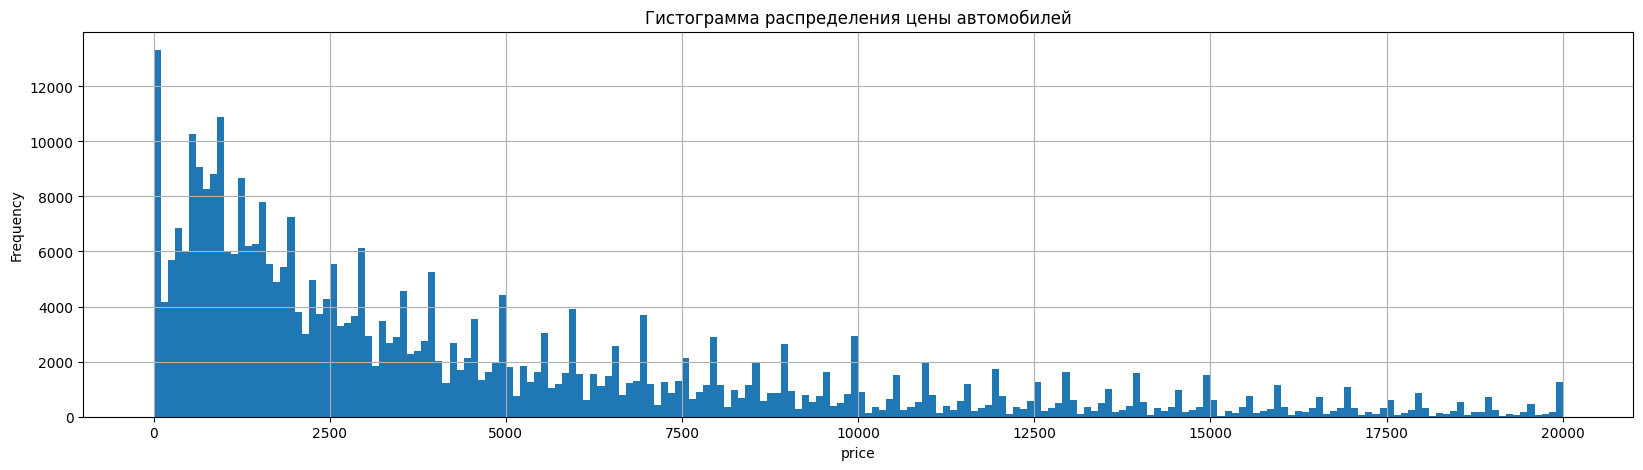

In [10]:
plt.title('Гистограмма распределения цены автомобилей')
plt.ylabel("Frequency")
plt.xlabel("price")
df_raw['Price'].hist(bins=200);

В таргете 10772 нулевых значений, они не соответствуют распределению.  
Нулевые значения в таргете - это пропуски, удаляем.  

In [11]:
# Преобразовываем датасет и выводим статистику

df = df_raw.copy()

preprocess_columns = Pipeline([
    ('rename_columns', FunctionTransformer(rename_columns)),
    ('create_model_name', FunctionTransformer(create_model_name)),
    ('filter_power', filter_power),
    ('filter_year', filter_year),
    ('filter_price', filter_price),
    ('drop_excess_columns', FunctionTransformer(drop_excess_columns)),
    ('drop_duplicates', FunctionTransformer(drop_excess_rows)),
    ('drop_target', FunctionTransformer(drop_target))
])

preprocess_columns.transform(df)
display_statistics(df)

,type,count,NaNs,zero_values,unique_values,freq_values,min,mean,max,std,lo_count,hi_count
price,float64,277180,0,0,3467,"{500.0: 4644, 1500.0: 4525, 1000.0: 3863}",500.0,4983.72,20000.0,4568.91,0,13436
vehicle_type,object,251745,25435,0,8,"{'sedan': 72837, 'small': 57391, 'wagon': 52310}",---,---,---,---,---,---
registration_year,float64,265028,12152,0,91,"{2005.0: 18438, 2006.0: 16955, 2000.0: 16899}",1923.0,2002.94,2016.0,6.91,6002,0
gearbox,object,265459,11721,0,2,"{'manual': 208782, 'auto': 56677}",---,---,---,---,---,---
power,float64,250742,26438,0,401,"{75.0: 16744, 150.0: 11993, 140.0: 10664}",10.0,123.51,500.0,53.66,0,6864
kilometer,int64,277180,0,0,13,"{150000: 179374, 125000: 30671, 100000: 12527}",5000,126937.08,150000,37915.16,---,---
fuel_type,object,254891,22289,0,7,"{'petrol': 166963, 'gasoline': 82388, 'lpg': 4...",---,---,---,---,---,---
repaired,object,227188,49992,0,2,"{'no': 202689, 'yes': 24499}",---,---,---,---,---,---
model_name,object,277180,0,0,337,"{'volkswagen golf': 21120, 'bmw 3er': 15539, '...",---,---,---,---,---,---


In [12]:
# Проверка после работы с признаками

df.duplicated().sum()

0

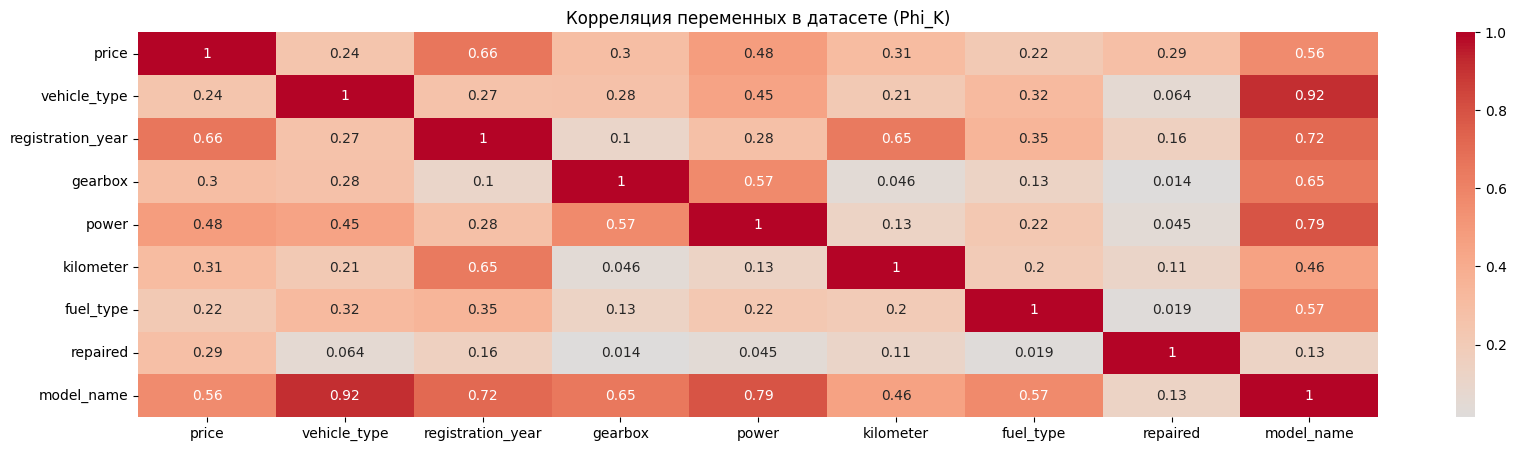

In [13]:
# Расчет зависимостей

interval_cols = ['price', 'power']
(
    sns.heatmap(df.phik_matrix(interval_cols=interval_cols), cmap='coolwarm', center=0, annot=True)
    .set_title('Корреляция переменных в датасете (Phi_K)')
);

Все признаки с малой кардинальностью закодированы, пропущенные значения обработаны, аномальные значения устранены.  

Для кодирования основной категориальной переменной оценим разные способы кодирования.  
Для категорий автомобилей применим кодирование по среднему значению таргета. Проверим это, расчитывая RMSE валидационной выборки, в качестве модели возьмем LGBMRegressor с настройками по умолчанию.

In [14]:
X_train, X_valid, X_test, y_train, y_valid, y_test = train_test_val_split(df, drop_target='price')

Обучающий набор: X: (194026, 8), y: (194026,)
Валидационный набор: X: (41577, 8), y: (41577,)
Тестовый набор: X: (41577, 8), y: (41577,)


In [15]:
def lgbmr_rmse(model_name, subsets):
    X_train, X_valid, X_test, y_train, y_valid, y_test = subsets
    model = LGBMRegressor(n_jobs=-1, verbosity=0)
    fit_predict_mark_time(model_name, model, X_train, y_train, X_valid, y_valid)

In [16]:
%%time
# Wall time: ~ 1min

params = {'data':df, 'drop_target':'price', 'silent':True}
lgbmr_rmse('TargetEncoder', encode(TargetEncoder, train_test_val_split(**params)))
lgbmr_rmse('CatBoostEncoder', encode(CatBoostEncoder, train_test_val_split(**params)))
lgbmr_rmse('BinaryEncoder', encode(BinaryEncoder, train_test_val_split(**params)))
lgbmr_rmse('OneHotEncoder', one_hot_encoder(train_test_val_split(**params)))
lgbmr_rmse('FeatureHasher', feature_hasher(train_test_val_split(**params)))

TargetEncoder:[default]             RMSE (train/valid): 1754.25/1824.28, time (fit/train/valid, s): 0/0/0
CatBoostEncoder:[default]           RMSE (train/valid): 1807.03/1867.33, time (fit/train/valid, s): 1/0/0
BinaryEncoder:[default]             RMSE (train/valid): 1829.34/1884.51, time (fit/train/valid, s): 0/0/0
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
OneHotEncoder:[default]             RMSE (train/valid): 1934.46/1984.0, time (fit/train/valid, s): 2/1/0
FeatureHasher:[default]             RMSE (train/valid): 2017.09/2064.25, time (fit/train/valid, s): 0/0/0
CPU times: total: 48 s
Wall time: 9.41 s


В данном случае TargetEncoder показал себя лучше остальных.

In [17]:
%%time
# Wall time: ~ 1min
X_encoded = encode(TargetEncoder, train_test_val_split(**params))

lgbmr_rmse('TargetEncoder', scale(StandardScaler(), X_encoded))
lgbmr_rmse('TargetEncoder', scale(MinMaxScaler(), X_encoded))
lgbmr_rmse('TargetEncoder', scale(RobustScaler(), X_encoded))
lgbmr_rmse('TargetEncoder', scale(QuantileTransformer(), X_encoded))


StandardScaler()    :TargetEncoder:[default]             RMSE (train/valid): 1756.26/1823.29, time (fit/train/valid, s): 0/0/0
MinMaxScaler()      :TargetEncoder:[default]             RMSE (train/valid): 1754.25/1824.28, time (fit/train/valid, s): 0/0/0
RobustScaler()      :TargetEncoder:[default]             RMSE (train/valid): 1755.59/1824.3, time (fit/train/valid, s): 0/0/0
QuantileTransformer():TargetEncoder:[default]             RMSE (train/valid): 1754.64/1826.52, time (fit/train/valid, s): 0/0/0
CPU times: total: 30.6 s
Wall time: 3.32 s


StandardScaler или другое масштабирование в нашем случае почти не влияет на точность.

**Выводы по п 1**
- импорт библиотек и загрузка данных прошла успешно
- удалены избыточные переменные, устранены пропуски и аномальные значения
- категориальные переменные закодированы
- подобран метод кодирования основной категориальной переменной model_name

## Обучение моделей

In [18]:
# Применяем OHE для категориальных переменных cat_columns c небольшим числом категорий до 10

df[['vehicle_type', 'gearbox', 'fuel_type', 'repaired']].nunique()

vehicle_type    8
gearbox         2
fuel_type       7
repaired        2
dtype: int64

In [19]:
df.isna().sum()

price                    0
vehicle_type         25435
registration_year    12152
gearbox              11721
power                26438
kilometer                0
fuel_type            22289
repaired             49992
model_name               0
dtype: int64

Используем TargetEncoder для высококардинальной model_name.  
Пропуски в vehicle_type, gearbox, fuel_type, repaired кодируются OneHotEncoder и исключаются.
Заполняем пропуски в оставшихся переменных power, vehicle_age средними значениями из категорий model_name.  
Оставшиеся пропуски (их единицы) - SimpleImputer.

In [20]:
cat_columns = ['vehicle_type', 'gearbox', 'fuel_type', 'repaired']

transformer = ColumnTransformer([
    ('cat_ohe', OneHotEncoder(drop=[np.nan]*len(cat_columns), sparse_output=False, handle_unknown='ignore'), cat_columns),
    ('cat_te', TargetEncoder(), ['model_name']),
], remainder='passthrough', verbose_feature_names_out=False)

process_columns = Pipeline([
    ('transformer', transformer),
    ('fillna_by_mean', FunctionTransformer(fillna_by_mean)),
    ('SimpleImputer', SimpleImputer())
])

In [21]:
X_train = process_columns.fit_transform(X_train, y_train)
X_valid = process_columns.transform(X_valid)
X_test = process_columns.transform(X_test)

Оценим несколько моделей кодом в стиле Lazy Predict, со всеми настройками по умолчанию.

In [22]:
models = [
    ('DummyRegressor', DummyRegressor()),
    ('LinearRegression', LinearRegression()),
    ('Ridge', Ridge(random_state=RANDOM_STATE)),
    ('ElasticNet', ElasticNet(random_state=RANDOM_STATE)),
    ('Lasso', Lasso(random_state=RANDOM_STATE)),
    ('DecisionTreeRegressor', DecisionTreeRegressor(random_state=RANDOM_STATE)),
    ('RandomForestRegressor', RandomForestRegressor(random_state=RANDOM_STATE)),
    ('GradientBoostingRegressor', GradientBoostingRegressor(random_state=RANDOM_STATE)),
    ('XGBRegressor', XGBRegressor(random_state=RANDOM_STATE)),
    ('HistGradientBoostingRegressor', HistGradientBoostingRegressor(random_state=RANDOM_STATE)),
    ('CatBoostRegressor', CatBoostRegressor(silent=True, random_state=RANDOM_STATE)),
    ('LGBMRegressor', LGBMRegressor(random_state=RANDOM_STATE, verbosity=0))
]

In [23]:
%%time
# Wall time: ~3 min

df_res = pd.DataFrame(columns=['train RMSE', 'valid RMSE', 'fit time', 
                               'predict train time', 'predict valid time', 'parameters'])

for model_name, model in models:
    result = fit_predict_mark_time(model_name, model, X_train, y_train, X_valid, y_valid)
    df_res.loc[model_name] = result

df_res.sort_values(by='valid RMSE')

DummyRegressor:[default]            RMSE (train/valid): 4558.55/4584.49, time (fit/train/valid, s): 0/0/0
LinearRegression:[default]          RMSE (train/valid): 2821.36/2854.87, time (fit/train/valid, s): 0/0/0
Ridge:[default]                     RMSE (train/valid): 2821.36/2854.86, time (fit/train/valid, s): 0/0/0
ElasticNet:[default]                RMSE (train/valid): 2923.26/2954.37, time (fit/train/valid, s): 0/0/0
Lasso:[default]                     RMSE (train/valid): 2821.92/2854.85, time (fit/train/valid, s): 0/0/0
DecisionTreeRegressor:[default]     RMSE (train/valid): 818.43/2194.4, time (fit/train/valid, s): 1/0/0
RandomForestRegressor:[default]     RMSE (train/valid): 973.78/1779.77, time (fit/train/valid, s): 49/5/1
GradientBoostingRegressor:[default] RMSE (train/valid): 1970.4/2011.42, time (fit/train/valid, s): 11/0/0
XGBRegressor:[default]              RMSE (train/valid): 1624.2/1775.69, time (fit/train/valid, s): 0/0/0
HistGradientBoostingRegressor:[default] RMSE (tra

,train RMSE,valid RMSE,fit time,predict train time,predict valid time,parameters
CatBoostRegressor,1641.56,1763.00,5,0,0,"{'loss_function': 'RMSE', 'silent': True, 'ran..."
XGBRegressor,1624.20,1775.69,0,0,0,"{'objective': 'reg:squarederror', 'base_score'..."
RandomForestRegressor,973.78,1779.77,49,5,1,"{'bootstrap': True, 'ccp_alpha': 0.0, 'criteri..."
LGBMRegressor,1769.93,1837.76,1,0,0,"{'boosting_type': 'gbdt', 'class_weight': None..."
HistGradientBoostingRegressor,1789.45,1856.07,1,0,0,"{'categorical_features': None, 'early_stopping..."
GradientBoostingRegressor,1970.40,2011.42,11,0,0,"{'alpha': 0.9, 'ccp_alpha': 0.0, 'criterion': ..."
DecisionTreeRegressor,818.43,2194.40,1,0,0,"{'ccp_alpha': 0.0, 'criterion': 'squared_error..."
Lasso,2821.92,2854.85,0,0,0,"{'alpha': 1.0, 'copy_X': True, 'fit_intercept'..."
Ridge,2821.36,2854.86,0,0,0,"{'alpha': 1.0, 'copy_X': True, 'fit_intercept'..."
LinearRegression,2821.36,2854.87,0,0,0,"{'copy_X': True, 'fit_intercept': True, 'n_job..."


Видим большую разницу по качеству по сравнению с baseline моделью DummyRegressor, а также с моделями линейной регрессии.  
CatBoostRegressor пока показал лучший, хотя и не самый быстрый, результат.    
Выберем для настройки гиперпараметров 3 модели: первые две и, следуя заданию, LGBMRegressor.

Для примера были взяты по паре значений из 2-3 важных гиперпараметров каждой модели, хотя у каждой модели их   
несколько десятков в широких диапазонах.  
Для реализации более обширного и точного подбора гиперпараметров будет необходимо работать с частью датасета,  
например, df.sample(10000).  
Но в данном ограниченном случае обрабатывается датасет целиком.  

In [24]:
# Последовательная генерация всевозможных сочетаний параметров из словаря d

def yield_next_param(d):
    for params in itertools.product(*d.values()):
        yield {k:v for (k,v) in zip(d.keys(), params)}

In [25]:
# Задание интервалов подбора гиперпараметров

model_params = [

    ['CatBoostRegressor()', 
     {'silent':True, 'random_state': RANDOM_STATE},
     {'iterations': [100, 300],
      'learning_rate': [0.01, 0.2],
      'depth': [6, 10]}
    ],
    
    ['XGBRegressor()', 
     {'random_state': RANDOM_STATE},
     {'n_estimators': [50, 250],
      'eta': [0.01, 0.2],
      'max_depth': [3, 7]}
    ],
    
    ['LGBMRegressor()', 
     {'random_state': RANDOM_STATE, 'verbosity': 0}, 
     {'n_estimators': [100, 200],
      'learning_rate': [0.01, 0.2],
      'num_leaves': [100, 200]}
    ]
]

In [26]:
%%time
for model_name, params, tune_params in model_params:
    best_model = [0, 1e10, 0, 0, 0, '']
    print('='*20, model_name, '='*20)
    for tune_param in yield_next_param(tune_params):
        model=eval(model_name)
        model.set_params(**params)
        model.set_params(**tune_param)
        result = fit_predict_mark_time(model_name, model, X_train, y_train, X_valid, y_valid, tune=tune_param)
        if best_model[1] > result[1]:
            best_model = result
    df_res.loc[model_name] = best_model
    
df_res.sort_values(by='valid RMSE')

==================== CatBoostRegressor() ====================
CatBoostRegressor():[100, 0.01, 6]  RMSE (train/valid): 2839.19/2860.59, time (fit/train/valid, s): 1/0/0
CatBoostRegressor():[100, 0.01, 10] RMSE (train/valid): 2662.81/2688.93, time (fit/train/valid, s): 2/0/0
CatBoostRegressor():[100, 0.2, 6]   RMSE (train/valid): 1815.57/1873.84, time (fit/train/valid, s): 1/0/0
CatBoostRegressor():[100, 0.2, 10]  RMSE (train/valid): 1688.05/1799.41, time (fit/train/valid, s): 2/0/0
CatBoostRegressor():[300, 0.01, 6]  RMSE (train/valid): 2115.82/2146.89, time (fit/train/valid, s): 2/0/0
CatBoostRegressor():[300, 0.01, 10] RMSE (train/valid): 1968.07/2012.58, time (fit/train/valid, s): 5/0/0
CatBoostRegressor():[300, 0.2, 6]   RMSE (train/valid): 1691.82/1790.51, time (fit/train/valid, s): 2/0/0
CatBoostRegressor():[300, 0.2, 10]  RMSE (train/valid): 1536.38/1733.3, time (fit/train/valid, s): 4/0/0
==================== XGBRegressor() ====================
XGBRegressor():[50, 0.01, 3]      

,train RMSE,valid RMSE,fit time,predict train time,predict valid time,parameters
LGBMRegressor(),1344.44,1696.69,1,0,0,"{'boosting_type': 'gbdt', 'class_weight': None..."
XGBRegressor(),1453.04,1728.63,1,0,0,"{'objective': 'reg:squarederror', 'base_score'..."
CatBoostRegressor(),1536.38,1733.30,4,0,0,"{'loss_function': 'RMSE', 'silent': True, 'ran..."
CatBoostRegressor,1641.56,1763.00,5,0,0,"{'loss_function': 'RMSE', 'silent': True, 'ran..."
XGBRegressor,1624.20,1775.69,0,0,0,"{'objective': 'reg:squarederror', 'base_score'..."
RandomForestRegressor,973.78,1779.77,49,5,1,"{'bootstrap': True, 'ccp_alpha': 0.0, 'criteri..."
LGBMRegressor,1769.93,1837.76,1,0,0,"{'boosting_type': 'gbdt', 'class_weight': None..."
HistGradientBoostingRegressor,1789.45,1856.07,1,0,0,"{'categorical_features': None, 'early_stopping..."
GradientBoostingRegressor,1970.40,2011.42,11,0,0,"{'alpha': 0.9, 'ccp_alpha': 0.0, 'criterion': ..."
DecisionTreeRegressor,818.43,2194.40,1,0,0,"{'ccp_alpha': 0.0, 'criterion': 'squared_error..."


In [27]:
# Найдены лучшие параметры

df_res.loc['LGBMRegressor()'].parameters

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.2,
 'max_depth': -1,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 200,
 'n_jobs': None,
 'num_leaves': 200,
 'objective': None,
 'random_state': 42,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0,
 'verbosity': 0}

Протестируем CatBoostRegressor (default iterations=1000) и LGBMRegressor (default n_estimators=100) с использованием внутренних кодировщиков категориальных переменных с минимальной предобработкой.

In [28]:
%%time
X_train_check, X_valid_check, _, y_train_check, y_valid_check, _ = train_test_val_split(df, drop_target='price', silent=True)
X_train_check.fillna("NaN", inplace=True)
X_valid_check.fillna("NaN", inplace=True)

cbr = CatBoostRegressor(silent=True, random_state=RANDOM_STATE, 
                        learning_rate=0.2, depth=10, 
                        cat_features=['vehicle_type', 'gearbox', 'fuel_type', 'repaired', 'model_name'])

fit_predict_mark_time('CatBoostRegressor (native)', cbr, X_train_check, y_train_check, X_valid_check, y_valid_check)

X_train_check, X_valid_check, _, y_train_check, y_valid_check, _ = train_test_val_split(df, drop_target='price', silent=True)
object_list = list(X_train_check.select_dtypes(include='object').columns)
X_train_check[object_list] = X_train_check[object_list].astype('category')
X_valid_check[object_list] = X_valid_check[object_list].astype('category')
lgbmr = LGBMRegressor(random_state=RANDOM_STATE, verbosity=-1, learning_rate= 0.2, num_leaves= 200)

_ = fit_predict_mark_time('LGBMRegressor(native)', lgbmr, X_train_check, y_train_check, X_valid_check, y_valid_check)

CatBoostRegressor (native):[default] RMSE (train/valid): 1431.46/1700.98, time (fit/train/valid, s): 96/1/0
LGBMRegressor(native):[default]     RMSE (train/valid): 1391.19/1683.23, time (fit/train/valid, s): 1/0/0
CPU times: total: 1min 6s
Wall time: 1min 38s


Результат с внутренними кодировщиками лучше, причем LGBMRegressor работает гораздо быстрее.

**Выводы по п 2**
- был предварительно протестирован с параметрами по умолчанию ряд регрессионных моделей, включая базовую модель
- по значениям RMSE на валидационной выборке были выбраны три модели: 
    - RandomForestRegressor
    - XGBRegressor
    - LGBMRegressor
- с помощью поиска по сетке были подобраны основные гиперпараметры для этих моделей

## Анализ моделей

Сравним время работы моделей с параметрами по умолчанию и с подобранными параметрами (скобки после названия модели):

In [29]:
df_res.sort_values(by='valid RMSE')

,train RMSE,valid RMSE,fit time,predict train time,predict valid time,parameters
LGBMRegressor(),1344.44,1696.69,1,0,0,"{'boosting_type': 'gbdt', 'class_weight': None..."
XGBRegressor(),1453.04,1728.63,1,0,0,"{'objective': 'reg:squarederror', 'base_score'..."
CatBoostRegressor(),1536.38,1733.30,4,0,0,"{'loss_function': 'RMSE', 'silent': True, 'ran..."
CatBoostRegressor,1641.56,1763.00,5,0,0,"{'loss_function': 'RMSE', 'silent': True, 'ran..."
XGBRegressor,1624.20,1775.69,0,0,0,"{'objective': 'reg:squarederror', 'base_score'..."
RandomForestRegressor,973.78,1779.77,49,5,1,"{'bootstrap': True, 'ccp_alpha': 0.0, 'criteri..."
LGBMRegressor,1769.93,1837.76,1,0,0,"{'boosting_type': 'gbdt', 'class_weight': None..."
HistGradientBoostingRegressor,1789.45,1856.07,1,0,0,"{'categorical_features': None, 'early_stopping..."
GradientBoostingRegressor,1970.40,2011.42,11,0,0,"{'alpha': 0.9, 'ccp_alpha': 0.0, 'criterion': ..."
DecisionTreeRegressor,818.43,2194.40,1,0,0,"{'ccp_alpha': 0.0, 'criterion': 'squared_error..."


In [30]:
df_res.loc[['CatBoostRegressor','CatBoostRegressor()', 
            'XGBRegressor', 'XGBRegressor()', 
            'LGBMRegressor', 'LGBMRegressor()']].sort_values(by='valid RMSE')

,train RMSE,valid RMSE,fit time,predict train time,predict valid time,parameters
LGBMRegressor(),1344.44,1696.69,1,0,0,"{'boosting_type': 'gbdt', 'class_weight': None..."
XGBRegressor(),1453.04,1728.63,1,0,0,"{'objective': 'reg:squarederror', 'base_score'..."
CatBoostRegressor(),1536.38,1733.30,4,0,0,"{'loss_function': 'RMSE', 'silent': True, 'ran..."
CatBoostRegressor,1641.56,1763.00,5,0,0,"{'loss_function': 'RMSE', 'silent': True, 'ran..."
XGBRegressor,1624.20,1775.69,0,0,0,"{'objective': 'reg:squarederror', 'base_score'..."
LGBMRegressor,1769.93,1837.76,1,0,0,"{'boosting_type': 'gbdt', 'class_weight': None..."


Модели с градиентным бустингом требуют больше времени для настройки, чем RandomForestRegressor.  
Однако время предсказания у них ниже.  
Если принять, что скорость настройки является менее значимым параметром, т.к. проводится один раз, то выбираем модель по критерию точности и скорости предсказания - LGBMRegressor.  
Для заказчика это будет выглядеть так:  
есть обновляемая база данных, один раз в день или чаще будет производиться настройка модели с заданной точностью, а при продаже автомобиля оценка стоимости будет занимать 5 s.

Окончательная настройка модели и проверка на тестовом наборе.

In [31]:
best_params = df_res.loc['LGBMRegressor()'].parameters
model = LGBMRegressor(**best_params)
model.get_params()

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.2,
 'max_depth': -1,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 200,
 'n_jobs': None,
 'num_leaves': 200,
 'objective': None,
 'random_state': 42,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0,
 'verbosity': 0}

In [32]:
df_res

,train RMSE,valid RMSE,fit time,predict train time,predict valid time,parameters
DummyRegressor,4558.55,4584.49,0,0,0,"{'constant': None, 'quantile': None, 'strategy..."
LinearRegression,2821.36,2854.87,0,0,0,"{'copy_X': True, 'fit_intercept': True, 'n_job..."
Ridge,2821.36,2854.86,0,0,0,"{'alpha': 1.0, 'copy_X': True, 'fit_intercept'..."
ElasticNet,2923.26,2954.37,0,0,0,"{'alpha': 1.0, 'copy_X': True, 'fit_intercept'..."
Lasso,2821.92,2854.85,0,0,0,"{'alpha': 1.0, 'copy_X': True, 'fit_intercept'..."
DecisionTreeRegressor,818.43,2194.40,1,0,0,"{'ccp_alpha': 0.0, 'criterion': 'squared_error..."
RandomForestRegressor,973.78,1779.77,49,5,1,"{'bootstrap': True, 'ccp_alpha': 0.0, 'criteri..."
GradientBoostingRegressor,1970.40,2011.42,11,0,0,"{'alpha': 0.9, 'ccp_alpha': 0.0, 'criterion': ..."
XGBRegressor,1624.20,1775.69,0,0,0,"{'objective': 'reg:squarederror', 'base_score'..."
HistGradientBoostingRegressor,1789.45,1856.07,1,0,0,"{'categorical_features': None, 'early_stopping..."


In [33]:
%%time

model_name = 'LGBMRegressor(test)'
df_res.loc[model_name] = fit_predict_mark_time(model_name, model, X_train, y_train, X_test, y_test);

LGBMRegressor(test):[default]       RMSE (train/valid): 1344.44/1665.9, time (fit/train/valid, s): 1/0/0
CPU times: total: 7.81 s
Wall time: 1.13 s


In [34]:
%%time
# Немного улучшит результат дообучение модели на валидационной выборке, т.к. добавится больше дополнительных данных о категориях

model_name = 'LGBMRegressor(train+valid -> test)'
df_res.loc[model_name] = fit_predict_mark_time(model_name, model,
                       pd.concat([X_train, X_valid]), 
                       pd.concat([y_train,y_valid]), X_test, y_test)

LGBMRegressor(train+valid -> test):[default] RMSE (train/valid): 1370.9/1647.42, time (fit/train/valid, s): 1/0/0
CPU times: total: 8.27 s
Wall time: 1.19 s


In [35]:
%%time
# Сравнение с константной моделью

model_name = 'DummyRegressor(test)'
df_res.loc[model_name] = fit_predict_mark_time(model_name, DummyRegressor(), X_train, y_train, X_test, y_test)
df_res.tail(3)

DummyRegressor(test):[default]      RMSE (train/valid): 4558.55/4601.58, time (fit/train/valid, s): 0/0/0
CPU times: total: 15.6 ms
Wall time: 3 ms


,train RMSE,valid RMSE,fit time,predict train time,predict valid time,parameters
LGBMRegressor(test),1344.44,1665.90,1,0,0,"{'boosting_type': 'gbdt', 'class_weight': None..."
LGBMRegressor(train+valid -> test),1370.90,1647.42,1,0,0,"{'boosting_type': 'gbdt', 'class_weight': None..."
DummyRegressor(test),4558.55,4601.58,0,0,0,"{'constant': None, 'quantile': None, 'strategy..."


**Выводы по п 3**
- проведен анализ времени работы и метрик результатов работы трех моделей
- по результатам этого анализа был выбрана модель LGBMRegressor
- выбранная модель LGBMRegressor была оценена на тестовой выборке
- была достигнуты целевые параметры модели RMSE = 1647.42 (< 2500), время настройки ~ 1 s, время предсказания ~ 0 s

**Общий вывод**

- импорт библиотек и загрузка данных прошла успешно, проведена подготовка данных и EDA
- категориальные переменные закодированы, масштабирование переменных не проводилось
- датасет большой, у категорий марок машин высокая кардинальность, таргет сильно зависит от этих категорий, поэтому лучшие результаты показывают модели, основанные на деревьях решений
- предварительно были выбраны три модели, после чего к ним были подобраны гиперпараметры
- проведен анализ времени работы и метрик результатов работы трех моделей
- по результатам этого анализа был выбрана модель LGBMRegressor
- была достигнута целевая метрика RMSE
- в проекте критическим оказался размер датасета, который сильно влияет на время вычислений, и, следовательно, на подбор модели и параметров. Для последующей оптимизации стоит протестировать случайный поиск, методы с байесовской оптимизацией, с ускорением поиска по сетке, фреймворк Optuna и т.д. 
- размер датасета предполагает сложную и медленную модель, отражающую всю таблицу значений категорий (у нас 336 основных категорий), поэтому, возможно, более высокие значения параметров деревьев приведут к повышению точности моделей, но существенно понизять скорость настройки и предсказаний
- в частности, для выбранной модели и особенностей датасета качество предсказания могли бы улучшить более высокие параметры n_estimators (> 500) и max_bin (>500)
- классическая модель RandomForestRegressor также не была протестирована полностью, более точный подбор параметров глубины и узлов деревьев улучшит результат
- имеющийся в свободном доступе широкий набор готовых методов позволяет построить модель предсказаний с требуемыми параметрами
- в нашем случае удалось построить модель для предсказания цены автомобилей с оптимальными параметрами